# PSyKE's demo

Some imports.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

from psyke import Extractor
from psyke.extraction.hypercubic.strategy import AdaptiveStrategy
from psyke.extraction.hypercubic import Grid, FeatureRanker
from psyke.utils.logic import pretty_theory
from psyke.utils import Target

Import iris dataset separating features and class.

In [18]:
x, y = load_iris(return_X_y=True, as_frame=True)

Rename of the features.

In [19]:
x.columns = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']

Replace integer indices with the corresponding string class.

In [20]:
y = pd.DataFrame(y).replace({"target": {0: 'setosa', 1: 'versicolor', 2: 'virginica'}})
y

,target
0,setosa
1,setosa
2,setosa
3,setosa
4,setosa
...,...
145,virginica
146,virginica
147,virginica
148,virginica


The final dataset:

In [21]:
dataset = x.join(y)
dataset.columns = [*dataset.columns[:-1], 'iris']
dataset

,SepalLength,SepalWidth,PetalLength,PetalWidth,iris
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Split between train and test set in a reproducible way.

In [22]:
train, test = train_test_split(dataset, test_size=0.5, random_state=0)

We use as predictor a KNN and we train it.

In [23]:
#predictor = MLPClassifier(alpha=1, max_iter=1000)
predictor = KNeighborsClassifier(n_neighbors=5)
#predictor = DecisionTreeClassifier()
predictor.fit(train.iloc[:, :-1], train.iloc[:, -1])
print(f'Accuracy: {accuracy_score(predictor.predict(test.iloc[:, :-1]), test.iloc[:, -1]):.2f}')
print(f'F1: {f1_score(predictor.predict(test.iloc[:, :-1]), test.iloc[:, -1], average="weighted"):.2f}')

Accuracy: 0.96
F1: 0.96


In [24]:
it = Extractor.iter(predictor, min_update=0.15, min_examples=150, threshold=0.1, max_iterations=600, n_points=1)
theory_from_iter = it.extract(train)
print('ITER performance ({} rules):\nAccuracy = {:.2f}\nFidelity = {:.2f}\nF1 = {:.2f}\nF1 = {:.2f}\n'
      .format(it.n_rules, it.accuracy(test), it.accuracy(test, predictor), it.f1(test), it.f1(test, predictor)))
print('ITER extracted rules:\n\n' + pretty_theory(theory_from_iter))

ITER performance (3 rules):
Accuracy = 0.91
Fidelity = 0.93
F1 = 0.91
F1 = 0.93

ITER extracted rules:

iris(PetalLength, PetalWidth, SepalLength, SepalWidth, setosa) :-
    SepalLength in [4.39, 7.90], SepalWidth in [2.19, 4.10], PetalLength in [1.19, 2.35], PetalWidth in [0.09, 2.50].
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, versicolor) :-
    SepalLength in [4.39, 7.90], SepalWidth in [2.19, 4.10], PetalLength in [2.35, 4.92], PetalWidth in [0.09, 2.50].
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, virginica) :-
    SepalLength in [4.39, 7.90], SepalWidth in [2.19, 4.10], PetalLength in [4.92, 6.90], PetalWidth in [0.09, 2.50].


We create a GridEx extractor to extract prolog rules from the same KNN.

In [25]:
ranked = FeatureRanker(x.columns).fit(predictor, x).rankings()
gridEx = Extractor.gridex(predictor, Grid(1, AdaptiveStrategy(ranked, [(0.85, 8)])), threshold=.1, min_examples=1)
theory_from_gridEx = gridEx.extract(train)
print('GridEx performance ({} rules):\nAccuracy = {:.2f}\nAccuracy fidelity = {:.2f}\nF1 = {:.2f}\nF1 = {:.2f}\n'
      .format(gridEx.n_rules, gridEx.accuracy(test), gridEx.accuracy(test, predictor),
              gridEx.f1(test), gridEx.f1(test, predictor)))
print('GridEx extracted rules:\n\n' + pretty_theory(theory_from_gridEx))

GridEx performance (3 rules):
Accuracy = 0.94
Accuracy fidelity = 0.96
F1 = 0.94
F1 = 0.96

GridEx extracted rules:

iris(PetalLength, PetalWidth, SepalLength, SepalWidth, setosa) :-
    PetalLength in [1.19, 1.91].
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, versicolor) :-
    PetalLength in [2.62, 4.76].
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, virginica) :-
    PetalLength in [4.76, 6.90].


We create an extractor that uses the CART algorithm and we extract prolog rules from our trained KNN.

In [26]:
cart = Extractor.cart(predictor, simplify=True)
theory_from_cart = cart.extract(train)
print('CART performance ({} rules):\nAccuracy = {:.2f}\nFidelity = {:.2f}\nF1 = {:.2f}\nF1 = {:.2f}\n'
      .format(cart.n_rules, cart.accuracy(test), cart.accuracy(test, predictor),
              cart.f1(test), cart.f1(test, predictor)))
print('\nCART extracted rules:\n\n' + pretty_theory(theory_from_cart))

CART performance (3 rules):
Accuracy = 0.92
Fidelity = 0.93
F1 = 0.92
F1 = 0.93


CART extracted rules:

iris(PetalLength, PetalWidth, SepalLength, SepalWidth, setosa) :-
    PetalLength =< 2.35.
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, versicolor) :-
    PetalWidth =< 1.55.
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, virginica).


In [27]:
from matplotlib.lines import Line2D
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors

size = (4, 3)
cmap = colors.ListedColormap(['b', 'r', 'g'])
bounds=[0,2,4,6]
norm = colors.BoundaryNorm(bounds, cmap.N)

def init():
    plt.figure(figsize = size)
    plt.gca().set_xlabel("Petal length (cm)")
    plt.gca().set_ylabel("Petal witdh (cm)")
    plt.xlim(train.PetalLength.min(), train.PetalLength.max())
    plt.ylim(train.PetalWidth.min(), train.PetalWidth.max())
    plt.gca().set_rasterized(True)

def plotSamples(df, name=None, marker=None):
    marks = [
        Line2D([0], [0], color = "b", marker = "x", lw = "0"),
        Line2D([0], [0], color = "r", marker = "*", lw = "0"),
        Line2D([0], [0], color = "g", marker = "+", lw = "0")
    ]

    df1 = df[df.iris == "setosa"]
    plot(df1["PetalLength"], df1["PetalWidth"], "b", "x" if marker is None else marker)

    df1 = df[df.iris == "versicolor"]
    plot(df1["PetalLength"], df1["PetalWidth"], "r", "*" if marker is None else marker)

    df1 = df[df.iris == "virginica"]
    plot(df1["PetalLength"], df1["PetalWidth"], "g", "+" if marker is None else marker)

    plt.gca().legend(marks, ['Setosa', 'Versicolor', 'Virginica'], loc = 4)
    if name is not None:
        plt.savefig("classification-{}.pdf".format(name), dpi = 500, bbox_inches = 'tight')
        plt.show()

def plotCube(X, y1, y2, c, cmap, A=.5):
    plt.gca().fill_between(X, y1, y2, color=cmap(norm(c)), ec=cmap(norm(c)), fc='none', alpha=A, hatch='//////////')

def plot(x, y, color, marker, A=.5):
    if marker == 's':
        plt.scatter(x, y, c=color, edgecolors=color, marker=marker, hatch='////', alpha=.5, s=9, lw=0)
    else:
        plt.scatter(x, y, c=color, marker=marker)

class_dict = {
    'setosa': 1,
    'versicolor': 3,
    'virginica': 5
}

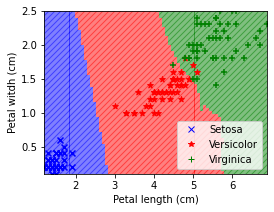

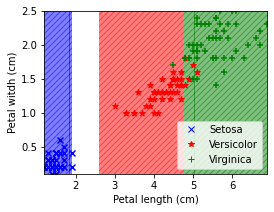

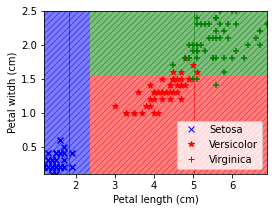

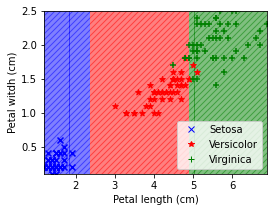

In [28]:
import numpy as np

model = 'knn'

n = 2
m = 70
x = np.linspace(train.SepalLength.min(), train.SepalLength.max(), n)
y = np.linspace(train.SepalWidth.min(), train.SepalWidth.max(), n)
w = np.linspace(1.2, 6.9, 76)
z = np.linspace(0.027, 2.5, 57)

xx, yy, ww, zz = np.meshgrid(x[0:2].mean(), y[0:2].mean(), w, z)
grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel(), ww.ravel(), zz.ravel()], columns=dataset.columns[:-1])

pred = gridEx.predict(grid)
idx = [p is not None for p in pred]

init()
plotSamples(pd.concat([grid, pd.DataFrame(predictor.predict(grid), columns=['iris'])], axis=1), marker='s')
plotSamples(dataset, f'{model}')

init()
plotSamples(pd.concat([grid, pd.DataFrame(gridEx.predict(grid), columns=['iris'])], axis=1), marker='s')
plotSamples(dataset, f'{model}-gridex')

init()
plotSamples(pd.concat([grid, pd.DataFrame(cart.predict(grid), columns=['iris'])], axis=1), marker='s')
plotSamples(dataset, f'{model}-cart')

init()
plotSamples(pd.concat([grid, pd.DataFrame(it.predict(grid), columns=['iris'])], axis=1), marker='s')
plotSamples(dataset, f'{model}-iter')

We use CReEPy and ORCHiD clustering-based extractors to perform the extraction.

In [29]:
exact = Extractor.exact(depth=2, error_threshold=0.1, output=Target.CLASSIFICATION)
_ = exact.extract(train)
exact.print()

Output is virginica if:
    SepalLength is in [5.70, 7.90]
    SepalWidth is in [2.50, 3.80]
    PetalLength is in [4.80, 6.90]
    PetalWidth is in [1.60, 2.50]
Output is versicolor if:
    SepalLength is in [4.90, 7.90]
    SepalWidth is in [2.20, 3.80]
    PetalLength is in [3.00, 6.90]
    PetalWidth is in [1.00, 2.50]
Output is setosa if:
    SepalLength is in [4.40, 7.90]
    SepalWidth is in [2.20, 4.10]
    PetalLength is in [1.20, 6.90]
    PetalWidth is in [0.10, 2.50]


In [30]:
creepy = Extractor.creepy(predictor, depth=2, error_threshold=0.1, output=Target.CLASSIFICATION,
                          ranks=ranked, ignore_threshold=.99)
theory_from_creepy = creepy.extract(train)
print('CReEPy performance ({} rules):\nAccuracy = {:.2f}\nFidelity = {:.2f}\n'
      .format(creepy.n_rules, creepy.accuracy(test), creepy.accuracy(test, predictor)))
print('CReEPy extracted rules:\n\n' + pretty_theory(theory_from_creepy))

CReEPy performance (3 rules):
Accuracy = 0.95
Fidelity = 0.96

CReEPy extracted rules:

iris(PetalLength, PetalWidth, SepalLength, SepalWidth, virginica) :-
    PetalLength in [4.79, 6.90].
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, versicolor) :-
    PetalLength in [2.99, 6.90].
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, setosa) :-
    PetalLength in [1.19, 6.90].


In [31]:
cream = Extractor.cream(depth=2, error_threshold=0.1, output=Target.CLASSIFICATION)
_ = cream.extract(train)
cream.print()

Output is setosa if:
    SepalLength is in [4.40, 5.80]
    SepalWidth is in [2.30, 4.10]
    PetalLength is in [1.20, 1.70]
    PetalWidth is in [0.10, 0.50]
Output is versicolor if:
    SepalLength is in [4.90, 6.70]
    SepalWidth is in [2.20, 3.20]
    PetalLength is in [3.00, 5.00]
    PetalWidth is in [1.00, 1.80]
Output is virginica if:
    SepalLength is in [4.40, 7.90]
    SepalWidth is in [2.20, 4.10]
    PetalLength is in [1.20, 6.90]
    PetalWidth is in [0.10, 2.50]


In [32]:
orchid = Extractor.orchid(predictor, depth=2, error_threshold=0.1, output=Target.CLASSIFICATION,
                          ranks=ranked, ignore_threshold=.99)
theory_from_orchid = orchid.extract(train)
print('ORCHiD performance ({} rules):\nAccuracy = {:.2f}\nFidelity = {:.2f}\n'
      .format(orchid.n_rules, orchid.accuracy(test), orchid.accuracy(test, predictor)))
print('ORCHiD extracted rules:\n\n' + pretty_theory(theory_from_orchid))

ORCHiD performance (3 rules):
Accuracy = 0.89
Fidelity = 0.90

ORCHiD extracted rules:

iris(PetalLength, PetalWidth, SepalLength, SepalWidth, setosa) :-
    PetalLength in [1.19, 1.70].
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, versicolor) :-
    PetalLength in [2.99, 4.90].
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, virginica) :-
    PetalLength in [1.19, 6.90].
